In [221]:
from importlib import reload
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.stats import ranksums, norm
import gseapy
from gseapy.plot import barplot, dotplot
from numpy.linalg import eigh, eig
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import time

import get_hic_map_of_selected_loci as hic

In [2]:
# Reload modules in case of modifications
reload(hic)

<module 'get_hic_map_of_selected_loci' from '/home/braunger/masterthesis/python_code/compare_hic/get_hic_map_of_selected_loci.py'>

## Settings

In [3]:
save_dir = '/home/braunger/masterthesis/save/'
fig_dir = '/home/braunger/masterthesis/save/figures/compare_hic/'
resol = 250000

In [321]:
def df_to_long(df):
    df.index.name = 'chr1'
    df.reset_index(inplace=True)
    df_long = pd.melt(df, id_vars = ['chr1'])
    df_long.columns = ['chr1', 'chr2', 'value']
    return(df_long)

In [129]:
selected_loci = pd.read_csv(save_dir+'pcst/DE_targets_FOS.csv')
selected_loci.head()

,gene,locus
0,C1orf159,chr_1_loc_1000000
1,DVL1,chr_1_loc_1250000
2,CDC20,chr_1_loc_43250000
3,KIF2C,chr_1_loc_44500000
4,KIF14,chr_1_loc_200500000


## 1. GSEA on clustered DE targets of FOS

In [87]:
cluster_FOS_targets = pd.read_csv(save_dir+'pcst/cluster_FOS_targets.csv')
cluster_FOS_targets.head()

,gene,cluster
0,ACTN4,1
1,ANLN,2
2,BUB1,2
3,C1orf159,1
4,C21orf58,3


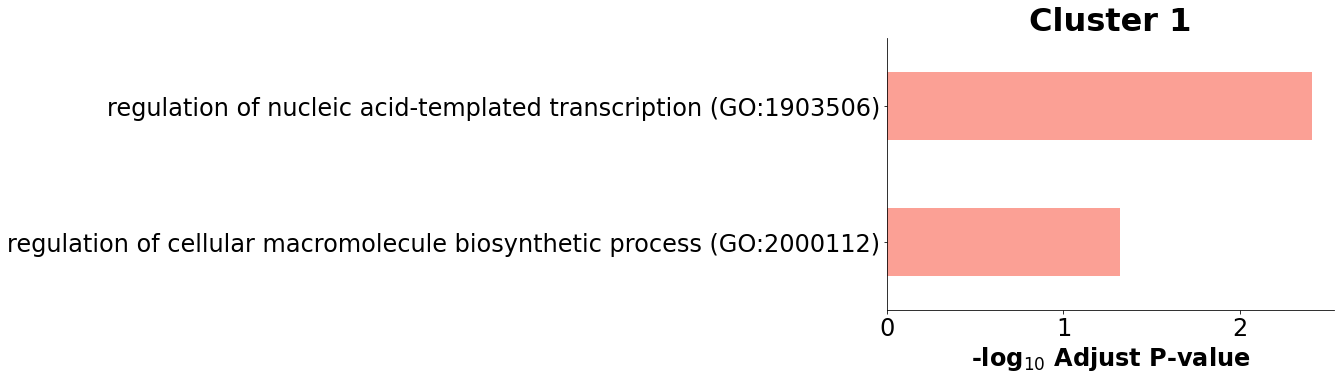

In [146]:
# GSEA on targets in cluster 1
enr = gseapy.enrichr(gene_list=cluster_FOS_targets.loc[cluster_FOS_targets['cluster'] == 1, 'gene'], 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_FOS', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 1',
        cutoff=0.05, top_term=20, figsize=(8, 5), color='salmon')

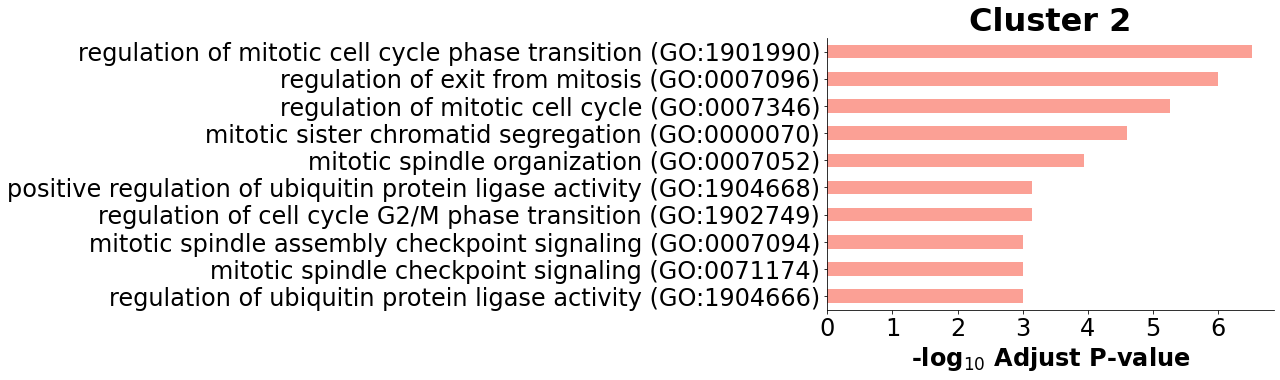

In [149]:
# GSEA on targets in cluster 2
enr = gseapy.enrichr(gene_list=cluster_FOS_targets.loc[cluster_FOS_targets['cluster'] == 2, 'gene'], 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_FOS', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 2',
        cutoff=0.05, top_term=10, figsize=(8, 5), color='salmon')

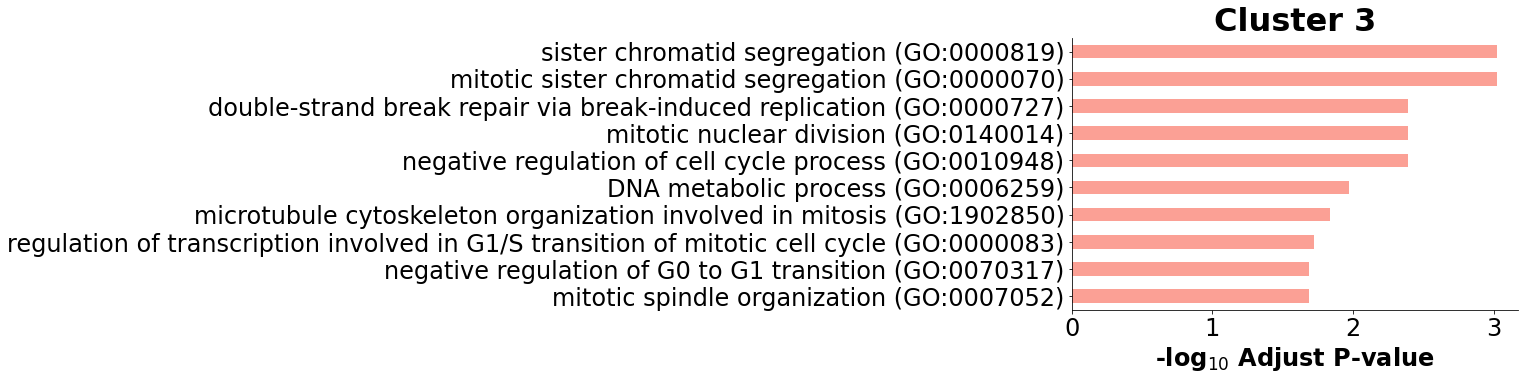

In [150]:
# GSEA on targets in cluster 3
enr = gseapy.enrichr(gene_list=cluster_FOS_targets.loc[cluster_FOS_targets['cluster'] == 3, 'gene'], 
                     gene_sets='GO_Biological_Process_2021', 
                     description='', outdir=save_dir+'GO_FOS', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='Cluster 3',
        cutoff=0.05, top_term=10, figsize=(8, 5), color='salmon')

# 2. Distribution of z-scored HiC data

In [297]:
IMR90_z = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_IMR90/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr1_chr2_zscore.txt', index_col = 0)
IMR90_z = IMR90_z.replace(np.min(IMR90_z, axis = 0), -5)
old_fibroblasts_z = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_old_fibroblasts/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr1_chr2_zscore.txt', index_col = 0)

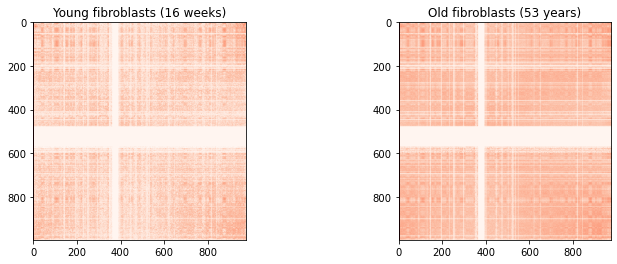

In [307]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs[0].imshow(IMR90_z.to_numpy(), cmap = 'Reds', vmin = -5, vmax = 16)
#sns.heatmap(IMR90_z, cmap = "Reds", ax = axs[0], xticklabels=False, yticklabels=False, vmin = -5, vmax = 16)
axs[0].set_ylabel('') 
axs[0].set_title('Young fibroblasts (16 weeks)')

axs[1].imshow(old_fibroblasts_z.to_numpy(), cmap = 'Reds', vmin = -5, vmax = 16)
#sns.heatmap(old_fibroblasts_z, cmap = "Reds", ax = axs[1], xticklabels=False, yticklabels=False, vmin = -5, vmax = 16)
axs[1].set_ylabel('') 
axs[1].set_title('Old fibroblasts (53 years)')
plt.show()

In [299]:
# conversion to long-format
IMR90_z_long = df_to_long(IMR90_z)
IMR90_z_long = IMR90_z_long[IMR90_z_long['value'] > np.min(IMR90_z_long['value'])]
IMR90_z_long['age'] = 'young'

old_fibroblasts_z_long = df_to_long(old_fibroblasts_z)
old_fibroblasts_z_long = old_fibroblasts_z_long[old_fibroblasts_z_long['value'] > np.min(old_fibroblasts_z_long['value'])]
old_fibroblasts_z_long['age'] = 'old'

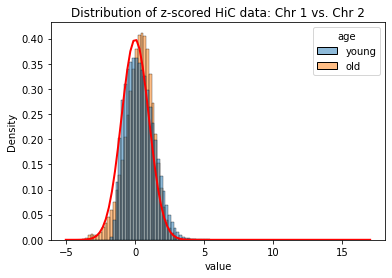

In [300]:
plt.figure()
ax = sns.histplot(data=pd.concat([IMR90_z_long, old_fibroblasts_z_long], ignore_index=True), x="value", 
             hue="age", bins = 100, stat = "density", common_norm = False)
#ax.axvline(x=IMR90_z_long.loc[:,'value'].mean(), color='blue')
#ax.axvline(x=old_fibroblasts_z_long.loc[:,'value'].mean(), color='orange')
ax.set_title('Distribution of z-scored HiC data: Chr 1 vs. Chr 2')

# add line of standard normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
ax.plot(x, p, 'r', lw=2, label='pdf')

plt.show()

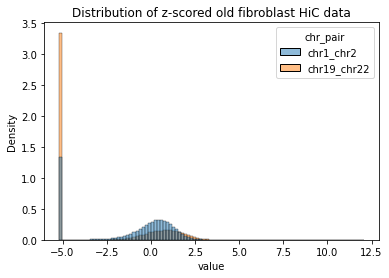

In [319]:
# Why are for old fibroblasts much more intermingling regions found for low chromosome numbers?

# load data for chr1 - chr 2
old_1_2 = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_old_fibroblasts/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr1_chr2_zscore.txt', index_col = 0)
old_1_2 = df_to_long(old_1_2)
old_1_2['chr_pair'] = 'chr1_chr2'

# load data for chr19 - chr 20
old_19_22 = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_old_fibroblasts/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr19_chr22_zscore.txt', index_col = 0)
old_19_22 = df_to_long(old_19_22)
old_19_22['chr_pair'] = 'chr19_chr22'

# plot histogram
plt.figure()
ax = sns.histplot(data=pd.concat([old_1_2, old_19_22], ignore_index=True), x="value", 
             hue="chr_pair", bins = 100, stat = "density", common_norm = False)
ax.set_title('Distribution of z-scored old fibroblast HiC data')
plt.show()

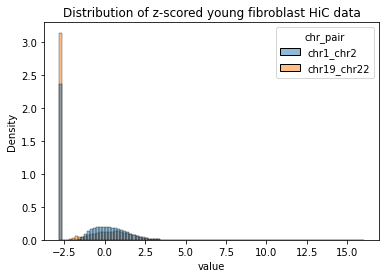

In [320]:
# load data for chr1 - chr 2
young_1_2 = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_IMR90/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr1_chr2_zscore.txt', index_col = 0)
young_1_2 = df_to_long(young_1_2)
young_1_2['chr_pair'] = 'chr1_chr2'

# load data for chr19 - chr 20
young_19_22 = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_IMR90/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr19_chr22_zscore.txt', index_col = 0)
young_19_22 = df_to_long(young_19_22)
young_19_22['chr_pair'] = 'chr19_chr22'

# plot histogram
plt.figure()
ax = sns.histplot(data=pd.concat([young_1_2, young_19_22], ignore_index=True), x="value", 
             hue="chr_pair", bins = 100, stat = "density", common_norm = False)
ax.set_title('Distribution of z-scored young fibroblast HiC data')
plt.show()

## Test rank-based inverse normal transformation

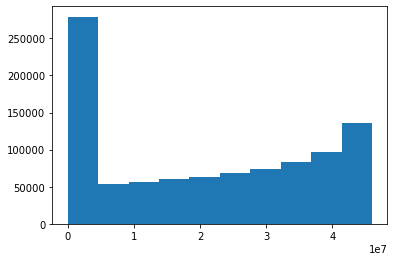

In [266]:
old_fibroblasts_z = pd.read_csv(save_dir + 'processed_hic_data/processed_hic_data_old_fibroblasts/' + 
                  'final_BP250000_intraKR_interINTERKR/hic_chr1_chr2_rank_INT.txt', index_col = 0)

plt.figure()
plt.hist(old_fibroblasts_z['rank'], bins = 10)
plt.show()

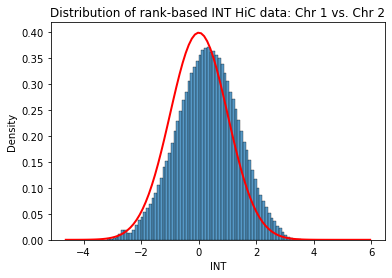

In [268]:
n = np.max(old_fibroblasts_z['rank'])
old_fibroblasts_z['INT'] = norm.ppf(old_fibroblasts_z['rank'] / (n+1))
old_fibroblasts_z = old_fibroblasts_z[old_fibroblasts_z['value'] > np.min(old_fibroblasts_z['value'])]

plt.figure()
ax = sns.histplot(data=old_fibroblasts_z, x="INT", 
             bins = 100, stat = "density", common_norm = False)
ax.set_title('Distribution of rank-based INT HiC data: Chr 1 vs. Chr 2')

# add line of standard normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)
ax.plot(x, p, 'r', lw=2, label='pdf')

plt.show()

# 3. FOS loci vs. random loci

## a) FOS loci

In [326]:
# Get Hi-C data for selected loci 
IMR90 = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/FOS_subset_z.csv', index_col = 0)
IMR90 = IMR90.replace(np.min(IMR90, axis = 0), -5)
old_fibroblasts = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/FOS_subset_z.csv', index_col = 0)

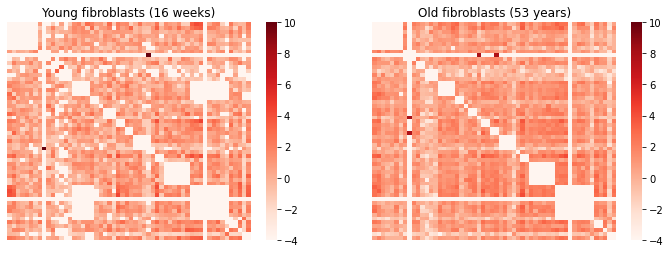

In [331]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.heatmap(IMR90, cmap = "Reds", ax = axs[0], xticklabels=False, yticklabels=False, vmin = -4, vmax = 10)
axs[0].set_ylabel('') 
axs[0].set_title('Young fibroblasts (16 weeks)')

sns.heatmap(old_fibroblasts, cmap = "Reds", ax = axs[1], xticklabels=False, yticklabels=False, vmin = -4, vmax = 10)
axs[1].set_ylabel('') 
axs[1].set_title('Old fibroblasts (53 years)')
plt.show()

## b) Random loci

In [332]:
# Get Hi-C data for selected loci 
IMR90_random = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/random_subset_z.csv', index_col = 0)
old_fibroblasts_random = pd.read_csv(save_dir+'processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/random_subset_z.csv', index_col = 0)

## c) Comparative histograms

In [333]:
IMR90_long = df_to_long(IMR90)
IMR90_long['loci'] = "FOS_DE_targets"
IMR90_long = IMR90_long[IMR90_long['value'] > np.min(IMR90_long['value'])]

old_fib_long = df_to_long(old_fibroblasts)
old_fib_long['loci'] = "FOS_DE_targets"
old_fib_long = old_fib_long[old_fib_long['value'] > np.min(old_fib_long['value'])]


IMR90_random_long = df_to_long(IMR90_random)
IMR90_random_long['loci'] = "random_loci"
IMR90_random_long = IMR90_random_long[IMR90_random_long['value'] > np.min(IMR90_random_long['value'])]

old_fib_random_long = df_to_long(old_fibroblasts_random)
old_fib_random_long['loci'] = "random_loci"
old_fib_random_long = old_fib_random_long[old_fib_random_long['value'] > np.min(old_fib_random_long['value'])]

IMR90_long.head()

,chr1,chr2,value,loci
7,chr_2_loc_10000000,chr_1_loc_1000000,0.862477,FOS_DE_targets
10,chr_3_loc_127500000,chr_1_loc_1000000,-1.219944,FOS_DE_targets
12,chr_5_loc_163250000,chr_1_loc_1000000,0.634969,FOS_DE_targets
14,chr_5_loc_179750000,chr_1_loc_1000000,-1.299537,FOS_DE_targets
15,chr_6_loc_30500000,chr_1_loc_1000000,1.385154,FOS_DE_targets


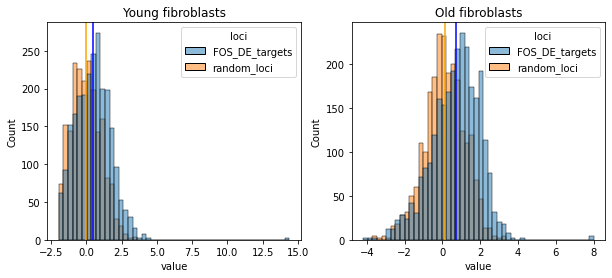

In [335]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(data=pd.concat([IMR90_long, IMR90_random_long], ignore_index=True), x="value", 
             hue="loci", bins = 50,  ax = axs[0])
axs[0].axvline(x=IMR90_long.loc[:,'value'].mean(), color='blue')
axs[0].axvline(x=IMR90_random_long.loc[:,'value'].mean(), color='orange')
axs[0].set_title('Young fibroblasts')

sns.histplot(data=pd.concat([old_fib_long, old_fib_random_long], ignore_index=True), x="value", 
             hue="loci", bins = 50, ax = axs[1])
axs[1].axvline(x=old_fib_long.loc[:,'value'].mean(), color='blue')
axs[1].axvline(x=old_fib_random_long.loc[:,'value'].mean(), color='orange')
axs[1].set_title('Old fibroblasts')

plt.savefig(fig_dir+'histogram_FOS_vs_random_loci_interactions.png')
plt.show()

## d) Significance test

In [ ]:
fname = save_dir+'processed_hic_data/processed_hic_data_IMR90/final_BP250000_intraKR_interINTERKR/random_subset_means_z.txt'
with open(fname, "r") as file:
    IMR90_means = file.read().replace('[', '').replace(']', '').split(", ")
    IMR90_means = [float(x) for x in IMR90_means]
    
fname = save_dir+'processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/random_subset_means_z.txt'
with open(fname, "r") as file:
    old_fibroblasts_means = file.read().replace('[', '').replace(']', '').split(", ")
    old_fibroblasts_means = [float(x) for x in old_fibroblasts_means]
    
means = pd.DataFrame({'young': IMR90_means, 
                       'old': old_fibroblasts_means})

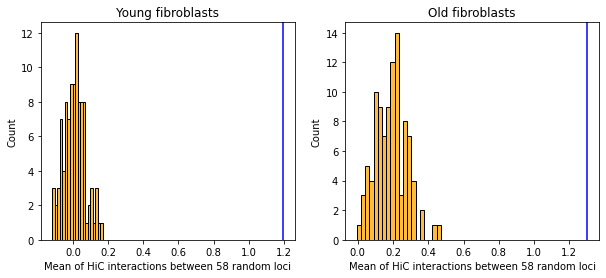

In [339]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(data=means, x="young", bins = 20,  color = 'orange', ax = axs[0])
axs[0].axvline(x=IMR90_long.loc[IMR90_long['value'] > 0,'value'].mean(), color='blue')
axs[0].set_title('Young fibroblasts')
axs[0].set_xlabel('Mean of HiC interactions between 58 random loci')

sns.histplot(data=means, x="old", bins = 20, color = 'orange', ax = axs[1])
axs[1].axvline(x=old_fib_long.loc[old_fib_long['value'] > 0,'value'].mean(), color='blue')
axs[1].set_title('Old fibroblasts')
axs[1].set_xlabel('Mean of HiC interactions between 58 random loci')

plt.savefig(fig_dir+'histogram_significance_FOS.png')
plt.show()